# Source term recovery in 1D Poisson equation

In [1]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from utils import Poisson
import cuqi

In [2]:
print("CUQI version:", cuqi.__version__)

CUQI version: 1.3.0


In [3]:
from cuqi.distribution import Gaussian, Gamma, JointDistribution
from cuqi.implicitprior import RegularizedGMRF
from cuqi.experimental.mcmc import LinearRTO, RegularizedLinearRTO, HybridGibbs, Conjugate, LinearRTO

In [4]:
import matplotlib 

fontsize = 20
legendfontsize = 20

matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

## Prepare forward model and synthetic data

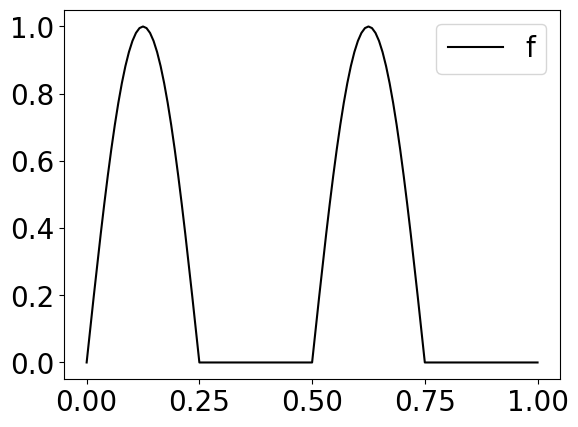

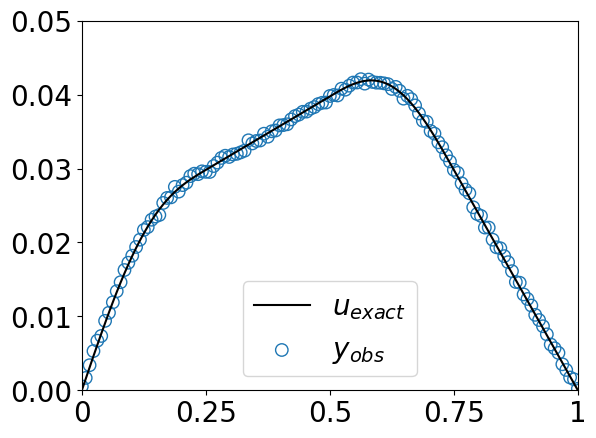

In [5]:
np.random.seed(0)

# %%
nx = 128
poisson = Poisson(nx)

signal_index = 1

if signal_index == 1:
    xx = np.linspace(0, 1, 128+1)
    x_exact = np.sin(4*np.pi*xx)
    x_exact[np.where(x_exact < 0)]=0
else:
    x_exact = np.zeros(nx+1)

    x_exact[25:35] = 0.5

    x_exact[45:60] = 1

    x_exact[80:95] = 0.8

plt.figure()
plt.plot(np.linspace(0,1,129), x_exact, label='f', color="k")
plt.legend(fontsize=legendfontsize, loc="upper right")

# %%
y_exact = poisson.forward(x_exact)

noise_scale = 3e-4#3e-4#1e-3#3e-3
noise = noise_scale*np.random.randn(y_exact.size)
y_data = y_exact + noise
# %%
plt.figure()
plt.plot(np.linspace(0,1,129), y_exact, label="$u_{exact}$", color="k")
plt.scatter(np.linspace(0,1,129), y_data, s=80, facecolors='none', edgecolors='C0', label="$y_{obs}$")
plt.legend(fontsize=legendfontsize, loc="lower center")
plt.ylim([0,0.05])
plt.xlim([0, 1])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'])
plt.savefig("rhs_data_sigma_03.pdf", bbox_inches='tight')

In [6]:
model_func = cuqi.model.LinearModel(poisson.forward, adjoint=poisson.adjoint, range_geometry=nx+1, domain_geometry=nx+1)

## GMRF with nonnegativity

In [7]:
# Regularized GMRF with Gibbs (to learn precision as well)
np.random.seed(0)
d = Gamma(1, 1e-4)
x = RegularizedGMRF(np.zeros(nx+1), prec = lambda d:d, constraint = "nonnegativity")
measure_variance = np.ones(nx+1)*noise_scale**2
y  = Gaussian(model_func(x), measure_variance)

# Combine into a joint distribution
joint = JointDistribution(d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO(maxit=50),
    'd': Conjugate()
}

sampler_rgmrf_gibbs = HybridGibbs(posterior, sampling_strategy)
sampler_rgmrf_gibbs.warmup(200)
sampler_rgmrf_gibbs.sample(10000)

samples_rgmrf_gibbs = sampler_rgmrf_gibbs.get_samples().burnthin(200)

Sample: 100%|██████████| 10000/10000 [31:57<00:00,  5.21it/s]


In [8]:
samples_rgmrf_gibbs['x'].geometry.grid = np.linspace(0,1,129)

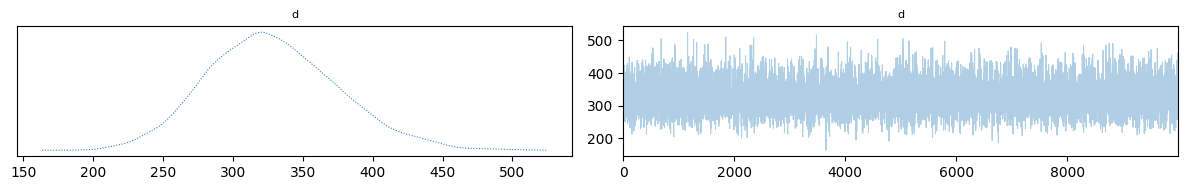

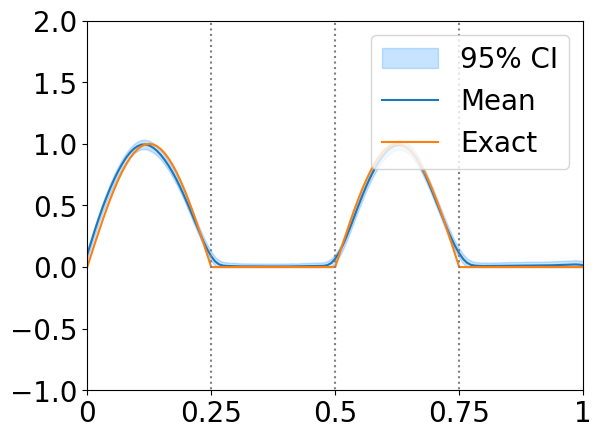

In [9]:
samples_rgmrf_gibbs['d'].plot_trace()
plt.figure()
samples_rgmrf_gibbs['x'].plot_ci(exact=x_exact)
plt.vlines([0.25, 0.5, 0.75], -3, 3, linestyles=':', colors='gray')
plt.xlim([0, 1])
plt.ylim([-1, 2])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'])
plt.legend(['95% CI', 'Mean', 'Exact'], fontsize=fontsize, loc="upper right")
plt.savefig("rhs_regularized_gmrf_gibbs_sigma_03.pdf", bbox_inches='tight')

# GMRF (reference)

In [10]:
# GMRF with Gibbs (to learn precision as well)
np.random.seed(1)
d = Gamma(1, 1e-4)
x = cuqi.distribution.GMRF(np.zeros(nx+1), prec = lambda d:d)
measure_variance = np.ones(nx+1)*noise_scale**2
y  = Gaussian(model_func(x), measure_variance)

# Combine into a joint distribution
joint = JointDistribution(d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': LinearRTO(maxit=50),
    'd': Conjugate()
}

sampler_gmrf_gibbs = HybridGibbs(posterior, sampling_strategy)
sampler_gmrf_gibbs.warmup(200)
sampler_gmrf_gibbs.sample(10000)
samples_gmrf_gibbs = sampler_gmrf_gibbs.get_samples().burnthin(200, 10)

Sample: 100%|██████████| 10000/10000 [23:47<00:00,  7.00it/s]


In [11]:
samples_gmrf_gibbs['x'].geometry.grid = np.linspace(0,1,129)

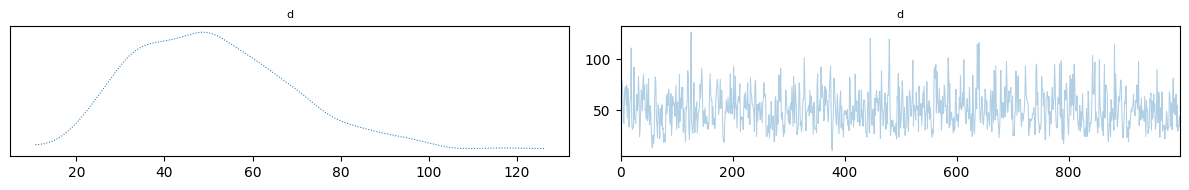

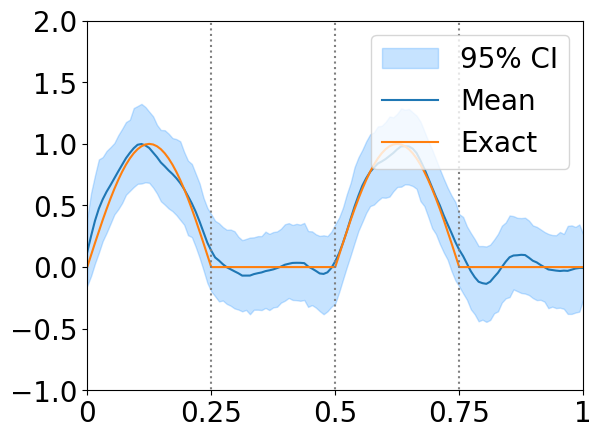

In [12]:
samples_gmrf_gibbs['d'].plot_trace()
plt.figure()
samples_gmrf_gibbs['x'].plot_ci(exact=x_exact)
plt.vlines([0.25, 0.5, 0.75], -3, 3, linestyles=':', colors='gray')
plt.xlim([0, 1])
plt.ylim([-1, 2])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'])
plt.legend(['95% CI', 'Mean', 'Exact'], fontsize=fontsize, loc="upper right")
plt.savefig("rhs_gmrf_gibbs_sigma_03.pdf", bbox_inches='tight')